## Import Packages

In [1]:
%matplotlib inline
import numpy as np
import collections
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

torch.manual_seed(42)
torch.set_printoptions(edgeitems=2)

## Data Preperations

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

from torchvision import datasets, transforms
data_path = '../down/cifar-10/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

Files already downloaded and verified
Files already downloaded and verified


## Training on GPU

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Training on device {device}.")

Training on device cuda.


In [4]:
import datetime as dt

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{}: Epoch {:0>2d}, Training loss: {}'.format(
                dt.datetime.now(), epoch, loss_train / len(train_loader)))

In [5]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [6]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-12-27 21:24:04.136956: Epoch 01, Training loss: 0.5477554388107009
2020-12-27 21:24:08.751513: Epoch 10, Training loss: 0.32743836882387756
2020-12-27 21:24:13.595410: Epoch 20, Training loss: 0.2898802727840509
2020-12-27 21:24:18.616266: Epoch 30, Training loss: 0.26690054926902623
2020-12-27 21:24:23.630150: Epoch 40, Training loss: 0.24753980756185617
2020-12-27 21:24:28.690816: Epoch 50, Training loss: 0.22892575791686964


## Model Baseline

In [7]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    
    for name, loader in [("train", train_loader), ("valid", val_loader)]:
        correct, total = 0, 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        accdict[name] = correct / total
        print("Accuracy {}: {:.2f}".format(name , correct / total))
    
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.90
Accuracy valid: 0.88


In [8]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

<All keys matched successfully>

## Model Width Design

In [9]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [10]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print()
all_acc_dict["width32"] = validate(model, train_loader, val_loader)

2020-12-27 21:24:29.475265: Epoch 01, Training loss: 0.5418027360348185
2020-12-27 21:24:33.912019: Epoch 10, Training loss: 0.3178438815721281
2020-12-27 21:24:38.782683: Epoch 20, Training loss: 0.27610594679595557
2020-12-27 21:24:43.781267: Epoch 30, Training loss: 0.2435441364053708
2020-12-27 21:24:48.670979: Epoch 40, Training loss: 0.21469198186306437
2020-12-27 21:24:53.483310: Epoch 50, Training loss: 0.18938815394404587

Accuracy train: 0.90
Accuracy valid: 0.88


In [11]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [12]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print()
all_acc_dict["width32"] = validate(model, train_loader, val_loader)

2020-12-27 21:24:54.281269: Epoch 01, Training loss: 0.5381686266060848
2020-12-27 21:24:58.659130: Epoch 10, Training loss: 0.3155044376090833
2020-12-27 21:25:03.431840: Epoch 20, Training loss: 0.27211988788501473
2020-12-27 21:25:08.202459: Epoch 30, Training loss: 0.23582879881000823
2020-12-27 21:25:13.055274: Epoch 40, Training loss: 0.2069964709270532
2020-12-27 21:25:17.940467: Epoch 50, Training loss: 0.18350385134197345

Accuracy train: 0.90
Accuracy valid: 0.88


## Model Regularization

In [13]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % 10 == 0:
            print('{}: Epoch {:0>2d}, Training loss: {}'.format(
                dt.datetime.now(), epoch, loss_train / len(train_loader)))

In [14]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print()
all_acc_dict["l2-reg"] = validate(model, train_loader, val_loader)

2020-12-27 21:25:18.991214: Epoch 01, Training loss: 0.610285352559606
2020-12-27 21:25:26.064784: Epoch 10, Training loss: 0.35443949927190305
2020-12-27 21:25:33.868093: Epoch 20, Training loss: 0.32074438842238895
2020-12-27 21:25:41.521030: Epoch 30, Training loss: 0.29852279441751495
2020-12-27 21:25:49.468157: Epoch 40, Training loss: 0.2798329342132921
2020-12-27 21:25:57.169697: Epoch 50, Training loss: 0.26363647401712503

Accuracy train: 0.89
Accuracy valid: 0.88


## Model Dropout

In [15]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [16]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print()
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2020-12-27 21:25:57.967642: Epoch 01, Training loss: 0.5619887855781871
2020-12-27 21:26:02.788832: Epoch 10, Training loss: 0.37239494340814605
2020-12-27 21:26:08.066624: Epoch 20, Training loss: 0.34669931413261756
2020-12-27 21:26:13.465327: Epoch 30, Training loss: 0.33050744928372133
2020-12-27 21:26:18.907841: Epoch 40, Training loss: 0.3166303885210851
2020-12-27 21:26:24.208747: Epoch 50, Training loss: 0.29583633971062434

Accuracy train: 0.87
Accuracy valid: 0.86


## Model BatchNorm

In [17]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [18]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print()
all_acc_dict["bat-norm"] = validate(model, train_loader, val_loader)

2020-12-27 21:26:25.152585: Epoch 01, Training loss: 0.4683299188021642
2020-12-27 21:26:30.439051: Epoch 10, Training loss: 0.2674688303926189
2020-12-27 21:26:36.372421: Epoch 20, Training loss: 0.20411465725131855
2020-12-27 21:26:42.423878: Epoch 30, Training loss: 0.1535399579887937
2020-12-27 21:26:48.323477: Epoch 40, Training loss: 0.10938137371069306
2020-12-27 21:26:54.187020: Epoch 50, Training loss: 0.07617985909199639

Accuracy train: 0.96
Accuracy valid: 0.89


## Model NetDepth

In [19]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [20]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print()
all_acc_dict["netdepth"] = validate(model, train_loader, val_loader)

2020-12-27 21:26:55.114559: Epoch 01, Training loss: 0.682493119103134
2020-12-27 21:27:00.160384: Epoch 10, Training loss: 0.3407067284462558
2020-12-27 21:27:05.961200: Epoch 20, Training loss: 0.2989848027373575
2020-12-27 21:27:11.817830: Epoch 30, Training loss: 0.2684810319144255
2020-12-27 21:27:17.506723: Epoch 40, Training loss: 0.2381876189807418
2020-12-27 21:27:23.267889: Epoch 50, Training loss: 0.207651804159781

Accuracy train: 0.88
Accuracy valid: 0.87


## Model NetRes

In [21]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [22]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print()
all_acc_dict["net-res"] = validate(model, train_loader, val_loader)

2020-12-27 21:27:24.158058: Epoch 01, Training loss: 0.6631431480881514
2020-12-27 21:27:29.471358: Epoch 10, Training loss: 0.33765792789732574
2020-12-27 21:27:35.219466: Epoch 20, Training loss: 0.29151152748211173
2020-12-27 21:27:41.036748: Epoch 30, Training loss: 0.2556220719199272
2020-12-27 21:27:46.781874: Epoch 40, Training loss: 0.22485817480049317
2020-12-27 21:27:52.680579: Epoch 50, Training loss: 0.19745993694871855

Accuracy train: 0.89
Accuracy valid: 0.88


## Model ResBlock

In [23]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [24]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [25]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print()
all_acc_dict["res-deep"] = validate(model, train_loader, val_loader)

2020-12-27 21:28:02.198899: Epoch 01, Training loss: 1.4288039194170836
2020-12-27 21:29:24.728259: Epoch 10, Training loss: 0.3004260933987654
2020-12-27 21:30:55.652672: Epoch 20, Training loss: 0.2176339295069883
2020-12-27 21:32:26.337681: Epoch 30, Training loss: 0.16135411401083516
2020-12-27 21:33:56.816603: Epoch 40, Training loss: 0.17762522321123225
2020-12-27 21:35:27.408995: Epoch 50, Training loss: 0.1403091109007787

Accuracy train: 0.94
Accuracy valid: 0.87


## Model Comparisons

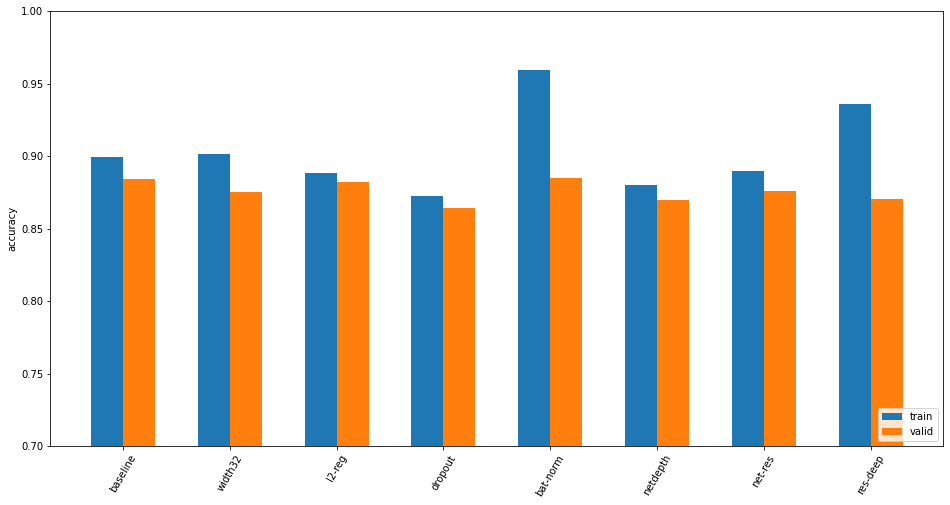

In [26]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['valid'] for k, v in all_acc_dict.items()]


width =0.3
plt.figure(figsize=(16, 8))
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='valid')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()), rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
# plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()